In [91]:
%autosave 0

Autosave disabled


# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [92]:
# module loads
import os
import re
import subprocess
import sys

import numpy as np
import pandas as pd

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30


# Performance and logging

from tqdm import tqdm
from tqdm import tnrange, tqdm_notebook
import logging
logging.basicConfig(level=logging.DEBUG,
                    format=' %(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

logging.disable(0) # switched debug on. 
logging.disable(logging.DEBUG) # debug and below not reported.
# logging.disable(logging.INFO)
# logging.disable(logging.WARNING)
# logging.disable(logging.ERROR)
# logging.disable(logging.CRITICAL)

#Import local utility notebooks:
if r'./util' not in sys.path: sys.path.append(r'./util')

# from notebook_import import *

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython import get_ipython
ipython = get_ipython()
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
## Visualizations
#import plotly.plotly as py
#import plotly.graph_objs as go
#from plotly.offline import iplot, init_notebook_mode
#init_notebook_mode(connected=True)
#import cufflinks as cf
#cf.go_offline(connected=True)
#cf.set_config_file(theme='white')

## local utility functions

In [93]:
def identify_type_of_day(date):
    weekno = date.weekday()
    #Ignoring the major study breaks as this is not much importance
    #if((date.month == 7 and week_of_month(date) < 4 ) or (date.month == 12 or date.month == 1 or date.month == 2)):
    #    return 'Major_study_break'
    if weekno>4:
        return 'Weekend'
    elif is_public_holiday(date):
        return 'Public_holiday'
    else:
        return 'Normal_Weekday'

#Week of month
from math import ceil

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """
    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

#Returns True if it's  public holiday
def is_public_holiday(dt):
    #public_holiday file for year 2017, use API/ file having multiple year's records to apply for different years
    public_holidays =  pd.read_csv('australianpublicholidays.csv', sep=',', encoding='ISO-8859-1', 
                                   parse_dates=['Date'],
                                   date_parser=lambda x: pd.to_datetime(x))
    """Instead API could be used : 
    import urllib
    url = 'https://data.gov.au/api/3/action/datastore_search?resource_id=253d63c0-af1f-4f4c-b8d5-eb9d9b1d46ab&limit=5&q=title:jones'  
#     fileobj = urllib.urlopen(url)
#     print (fileobj.read())
    public_holidays = pd.read_csv(url, sep=',', encoding='ISO-8859-1', parse_dates=['Date'],
                 date_parser=lambda x: pd.to_datetime(x))
    """
    
    #get public holidays of SA only
    public_holidays_SA = public_holidays[public_holidays['Applicable To'].str.contains("SA") | public_holidays['Applicable To'].str.contains("NAT")]
    
    #Return True if each date is public holiday in SA
    return pd.to_datetime(dt).date() in (public_holidays_SA['Date'].apply(lambda x: datetime.date(x))).values


In [94]:
#reads a csv file, adds a day type column, creates a csv file with day type column and returns a dataframe object with day type
def add_day_type_column(file, date_column):
    data_file = pd.read_csv(file, sep=',', encoding='ISO-8859-1', parse_dates=[date_column],
                 date_parser=lambda x: pd.to_datetime(x.rsplit(' ', 1)[0]))
    data_file['Type_of_day'] = data_file[date_column].apply(lambda x: identify_type_of_day(datetime.date(x)))
    file_name = file + '_with_day_type.csv'
    #uncomment next line if you want a new file to be created with day type column
    #data_file.to_csv(file_name, sep=',', encoding='utf-8')
    return data_file


In [95]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# ### estimate campus power
# 
# The bulk of the data is for kVA values. Estimated the real power drawn from this based on the mean power factor for the data we did have. 

# In[8]:

def campus_power_estimation(bms):
    """Estimate real power form kVA value based on average pf of the 
        small set of paired values we do have
    """
    
    #bms[bms['ML_PH/Main_11kV_kW (kW)'] > 0.0]['ML_PH/Main_11kV_kW (kW)'] / bms[bms['ML_PH/Main_11kV_kW (kW)'] > 0.0]['ML_PH/Main_11kV_kVA (kVA)']

   #if logger.getEffectiveLevel() < logging.INFO: 
        #plt.scatter(bms[bms['ML_PH/Main_11kV_kW (kW)'] > 0.0]['ML_PH/Main_11kV_kW (kW)'], 
         #           bms[bms['ML_PH/Main_11kV_kW (kW)'] > 0.0]['kVA'], 
          #          alpha=0.05)
        #plt.title('Power factor scatter plot.'); 
        #plt.show()
    
    bms['kW_est'] = bms['kVA'] * 0.92
    # use original values where I have them: 
    #bms['kW_est'] = np.where(bms['kW'] == 0.0, bms['kW_est'], bms['kW'])
    return bms


not sure I need this one anymore!

In [96]:
#replace zero's with previous year values
def replace_zeros(bms,bms_lastyear):
    #replace year in timestamp
    bms_lastyear_copy = bms_lastyear.reindex(bms.index, method='nearest')
    
    imputed_df = bms.where(bms['kVA'] == 0 | bms['kVA'].isna(), bms_lastyear_copy['kVA'],axis=0)
    return imputed_df

# load the data

In [97]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import logging

In [98]:
os.path.abspath(os.curdir)

'C:\\Users\\ciroccol\\Dropbox\\_repo\\Relevant data\\Capstone'

In [99]:
# Change file_path as necessary
file_path = "../Relevant data/Capstone" 
file_path = "C:\\Users\\ciroccol\\Dropbox\\_repo\\Relevant data\\Capstone"

os.chdir(file_path)

In [100]:
tz = pytz.timezone('Australia/Adelaide')

In [101]:
bms_all_safe = pd.read_excel("PH-30min-SafeCopy.xlsx", sheet_name=None)
for k in ['b', 'c', 'Sheet1']: del bms_all_safe[k]

C:\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1204: UnknownTimezoneWarning: tzname CST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


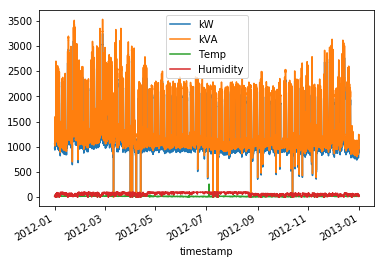

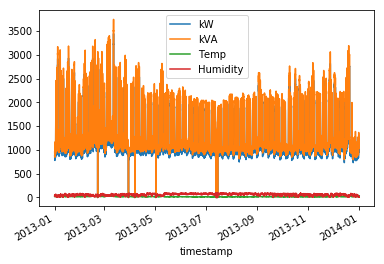

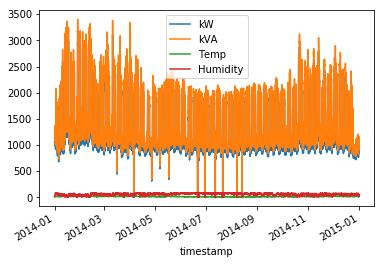

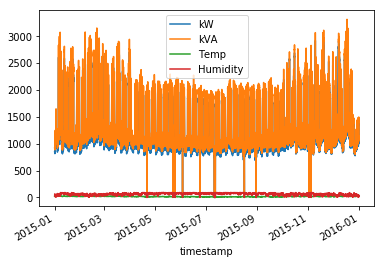

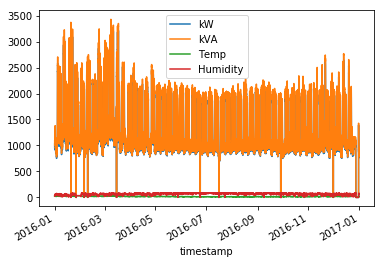

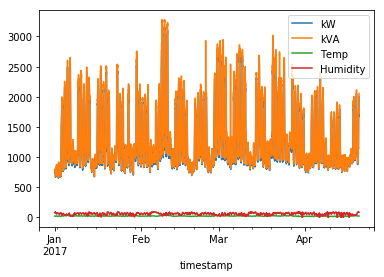

In [102]:
bms_all = bms_all_safe.copy()
bms_complete = pd.DataFrame()
for k in bms_all.keys():
    bms_all[k] = bms_all[k]
    bms_all[k] = bms_all[k][:-3]
    bms_all[k] = bms_all[k].drop_duplicates(subset='timestamp', keep='first')
    
    bms_all[k].set_index('timestamp', drop=True, append=False, inplace=True, verify_integrity=False)
    bms_all[k].index = pd.to_datetime( bms_all[k].index, infer_datetime_format=True)
    
    bms_all[k].rename(columns={'ML_PH/Main_11kV_kW (kW)':'kW',
                               'ML_PH/Main_11kV_kVA (kVA)':'kVA',
                               'ML_PH/PH_Ambient_Temperature (Â°C)':'Temp',
                               'ML_PH/PH_Ambient_Humidity (%RH)':'Humidity'}, inplace=True)
    bms_all[k]['kW'] =  bms_all[k]['kW'].where( bms_all[k]['kW']!=0.0,   bms_all[k]['kVA'] * 0.92)
    bms_all[k]['Humidity'] =  bms_all[k]['Humidity'].where( bms_all[k]['Humidity']<=100.0,  100.0)
#     bms_all[k]['Type_of_day'] = ['Weekday' if x.weekday() <= 4 else 'Weekend' for x in bms_all[k].index]
    bms_all[k]['Type_of_day'] = [identify_type_of_day(x) for x in bms_all[k].index]
    
    
    bms_complete = bms_complete.append(bms_all[k][['kW', 'kVA', 'Temp', 'Humidity', 'Type_of_day']])
                              
    bms_all[k][['kW', 'kVA', 'Temp', 'Humidity']].plot.line()
    plt.show()

In [103]:
bms_complete['Type_of_day'] = [identify_type_of_day(x) for x in bms_complete.index]

In [104]:
bms_complete.to_csv("bms_complete.csv", sep=',', encoding='utf-8')

## a bit of a dud!

In [105]:
bms_all_1718 = pd.read_csv("BMS.csv", sep=',', encoding='ISO-8859-1')
bms_all_1718.rename(columns={'ML_PH/Main_11kV_kW (kW)':'kW',
                             'ML_PH/Main_11kV_kVA (kVA)':'kVA',
                             'ML_PH/PH_Ambient_Temperature (°C)':'Temp',
                             'ML_PH/PH_Ambient_Humidity (%RH)':'Humidity'}, inplace=True)

In [106]:
print('\n'.join(bms_all_1718.columns))

?Timestamp
?Timestamp.1
Humidity
Temp
ML_PH/PH_CHW_Demands_A_CHW_Demand (°C)
ML_PH/PH_CHW_Demands_CHW_Setpoint (°C)
ML_PH/PH_CHW_Demands_C_CHW_Demand (°C)
ML_PH/PH_CHW_Demands_C_old_CHW_Demand (°C)
ML_PH/PH_CHW_Demands_E_CHW_Demand (°C)
ML_PH/PH_CHW_Demands_F_CHW_Demand (°C)
ML_PH/PH_CHW_Demands_GP_CHW_Demand (°C)
ML_PH/PH_CHW_Demands_G_CHW_Demand (°C)
ML_PH/PH_CHW_Demands_H_CHW_Demand (°C)
ML_PH/PH_CHW_Demands_J_CHW_Demand (°C)
ML_PH/PH_CHW_Demands_MC_CHW_Demand (°C)
ML_PH/PH_CHW_Demands_M_CHW_Demand (°C)
ML_PH/PH_CHW_Demands_MinDemand (°C)
ML_PH/PH_CHW_Demands_N_CHW_Demand (°C)
ML_PH/PH_CHW_Demands_OC_CHW_Demand (°C)
ML_PH/PH_CHW_Demands_P_CHW_Demand (°C)
ML_PH/PH_CHW_Demands_Q_CHW_Demand (°C)
ML_PH/PH_CHW_Demands_R_CHW_Demand (°C)
ML_PH/PH_CHW_Demands_SCT_CHW_Demand (°C)
ML_PH/PH_CHW_Demands_V_CHW_Demand (°C)
ML_PH/PH_CHW_Demands_X_CHW_Demand (°C)
ML_PH/PH_Chiller_Staging_CHW_Flow (L/s)
ML_PH/PH_Chiller_Staging_CHW_ReturnTemp (°C)
ML_PH/PH_Chiller_Staging_CHW_SupplyTemp (°C)
ML_PH/P

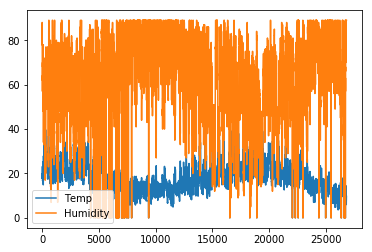

In [107]:
bms_all_1718[['Temp', 'Humidity']].plot.line()

# Analysis/Modeling
Do work here

Text(0,0.5,'kW')

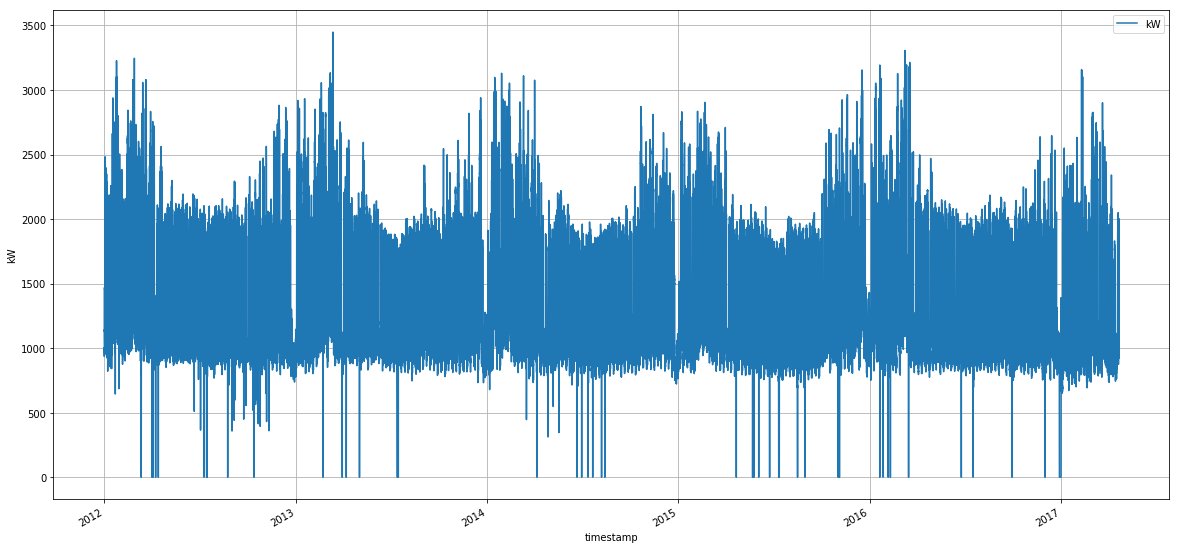

In [108]:
ax = bms_complete.plot(y='kW' ,figsize=(20,10), grid=True, use_index=True)
ax.set_ylabel("kW")

Text(0,0.5,'kW')

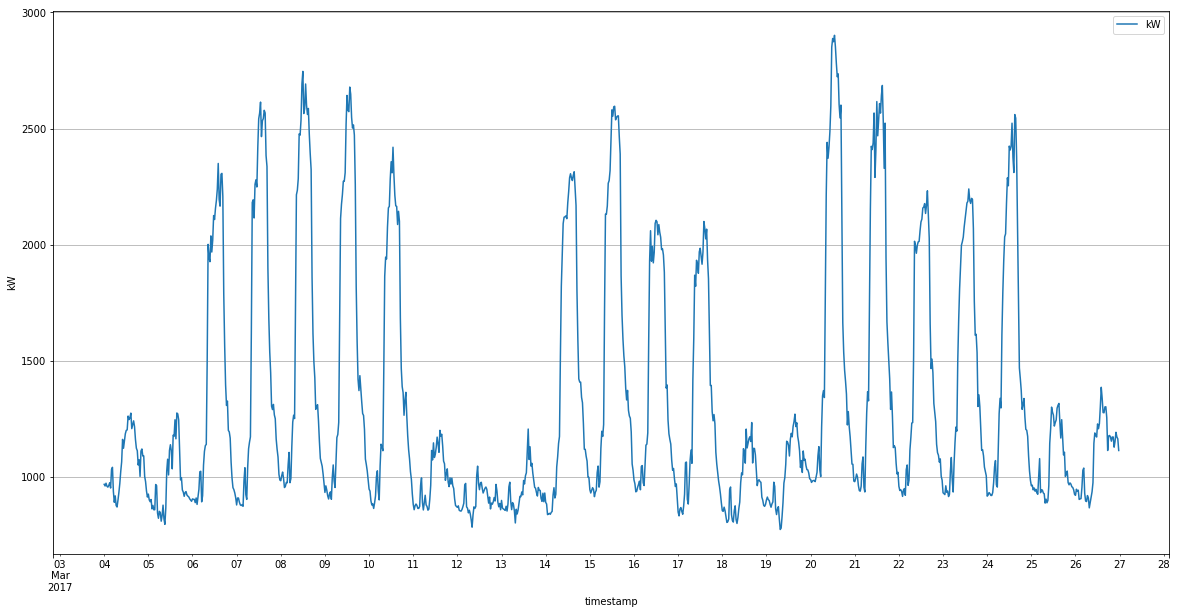

In [109]:
ax1 = bms_complete.loc["2017-03-04":"2017-03-26"].plot(y='kW' ,figsize=(20,10), grid=True, use_index=True)
ax1.set_ylabel("kW")

In [110]:
bms_complete['Type_of_day'] = [identify_type_of_day(x) for x in bms_complete.index]

Type_of_day
Normal_Weekday    1445.462406
Public_holiday    1010.721000
Weekend            967.896142
Name: kW, dtype: float64

Text(0,0.5,'Average daily kW')

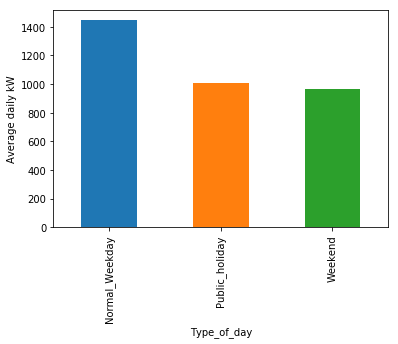

In [111]:
grouped_by_daytype = bms_complete.groupby(['Type_of_day'])['kW'].mean()
grouped_by_daytype
ax = grouped_by_daytype.plot.bar()
ax.set_ylabel("Average daily kW")

                kW      Temp  Humidity
kW        1.000000  0.433471 -0.268589
Temp      0.433471  1.000000 -0.645341
Humidity -0.268589 -0.645341  1.000000


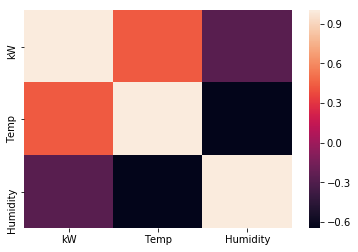

In [112]:
corr_val = bms_complete[['kW', 'Temp', 'Humidity']].corr()
print (corr_val)
import seaborn as sns
sns.heatmap(corr_val, 
        xticklabels=corr_val.columns,
        yticklabels=corr_val.columns)


                kW      Temp  Humidity
kW        1.000000  0.507522 -0.354524
Temp      0.507522  1.000000 -0.662519
Humidity -0.354524 -0.662519  1.000000


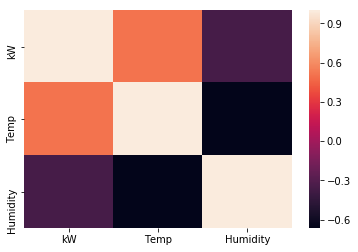

In [113]:
corr_val = bms_complete[['kW', 'Temp', 'Humidity']][bms_complete.Type_of_day == 'Normal_Weekday'].reset_index().corr()
print (corr_val)
import seaborn as sns
sns.heatmap(corr_val, 
        xticklabels=corr_val.columns,
        yticklabels=corr_val.columns)

                kW      Temp  Humidity
kW        1.000000  0.693176 -0.250842
Temp      0.693176  1.000000 -0.608160
Humidity -0.250842 -0.608160  1.000000


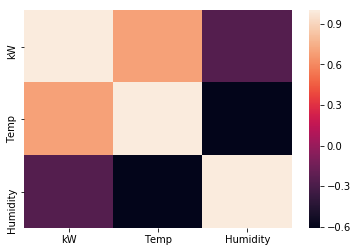

In [114]:
corr_val = bms_complete[['kW', 'Temp', 'Humidity']][bms_complete.Type_of_day != 'Normal_Weekday'].reset_index().corr()
print (corr_val)
import seaborn as sns
sns.heatmap(corr_val, 
        xticklabels=corr_val.columns,
        yticklabels=corr_val.columns)

# now for the fun stuff


In [115]:
import math
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults

In [116]:
tranining_data = bms_complete["2012":"2016"].copy()
demand = bms_complete["2012":"2016"]['kW']

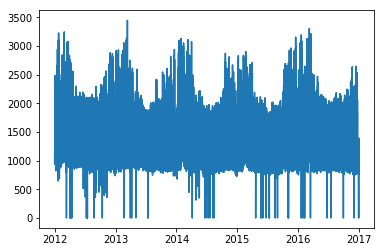

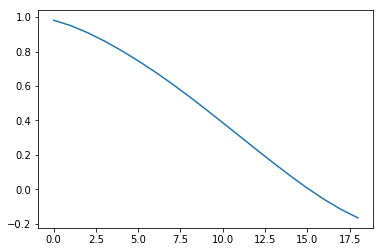

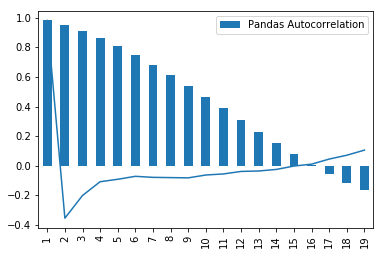

(-41.128097922322944,
 0.0,
 1,
 87684,
 {'1%': -3.4304245802135824,
  '5%': -2.8615729632349374,
  '10%': -2.566787545185387},
 1032275.279370216)

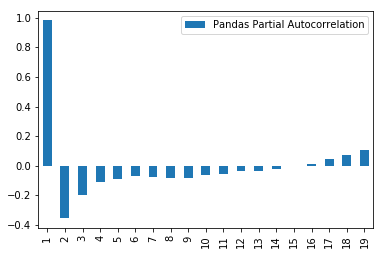

In [117]:
plt.plot(demand)
plt.show()
acf_1 =  acf(demand)[1:20]
plt.plot(acf_1)
plt.show()
test_df = pd.DataFrame([acf_1]).T
test_df.columns = ['Pandas Autocorrelation']
test_df.index += 1
test_df.plot(kind='bar')
pacf_1 =  pacf(demand)[1:20]
plt.plot(pacf_1)
plt.show()
test_df = pd.DataFrame([pacf_1]).T
test_df.columns = ['Pandas Partial Autocorrelation']
test_df.index += 1
test_df.plot(kind='bar')
result = ts.adfuller(demand, 1)
result

In [118]:
demand_matrix=demand.as_matrix()
model = ARIMA(demand_matrix, order=(3,1,3))
model_fit = model.fit(disp=0)
fits = model_fit.fittedvalues
residuals = model_fit.resid
print(model_fit.summary())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                87685
Model:                 ARIMA(3, 1, 3)   Log Likelihood             -510520.765
Method:                       css-mle   S.D. of innovations             81.717
Date:                Sun, 30 Jun 2019   AIC                        1021057.530
Time:                        07:41:21   BIC                        1021132.582
Sample:                             1   HQIC                       1021080.442
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.160     -0.019      0.985      -0.317       0.311
ar.L1.D.y      2.2341      0.017    132.907      0.000       2.201       2.267
ar.L2.D.y     -1.5062      0.033    -45.460      0.0

In [119]:
fits = np.concatenate([[0],fits])

In [120]:
tranining_data['fits'] = tranining_data['kW'] + fits

In [122]:
tranining_data['err'] = fits

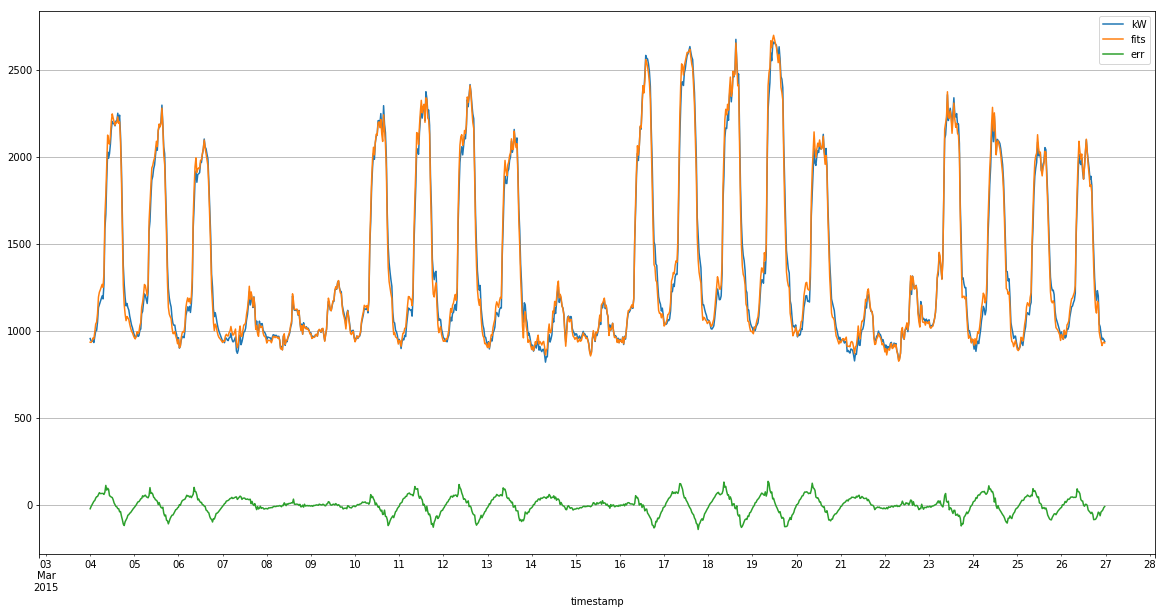

In [123]:
tranining_data.loc["2015-03-04":"2015-03-26"].plot(y=['kW','fits', 'err'] ,figsize=(20,10), grid=True, use_index=True, legend=True)

In [124]:
#ARIMAX model
arimax_model=ARIMA(endog=tranining_data[['kW']],exog=tranining_data[['Temp','Humidity']],order=[3,1,3])
results3=arimax_model.fit()
print(results3.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                   D.kW   No. Observations:                87685
Model:                 ARIMA(3, 1, 3)   Log Likelihood             -510506.302
Method:                       css-mle   S.D. of innovations             81.703
Date:                Sun, 30 Jun 2019   AIC                        1021032.604
Time:                        07:55:13   BIC                        1021126.419
Sample:                             1   HQIC                       1021061.244
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.9248      1.246     -4.757      0.000      -8.366      -3.484
Temp           0.1860      0.035      5.260      0.000       0.117       0.255
Humidity       0.0412      0.011      3.586      0.0

# Results
Show graphs and stats here

# Conclusions and Next Steps
Summarize findings here